In [ ]:

import days.gpt2 as gpt2
import days.bert as bert

import matplotlib.pyplot as plt

## Let's visualize attention matrices from a causal language model

We're going to use register_forward_hook to extract the attention patterns from our transformer.

Make a function from a string to the attention patterns for every head in every layer in the model

Once you have an attention pattern, you can visualize it with our function display_attention below. It's made with HTML/CSS, which is significantly better than matplotlib or whatever for this application, and it'd be a big diversion to write it yourselves.

In [ ]:
from IPython.core.display import HTML, display
import torch as t
def display_attention(attn_matrix, tokens):
    attn_matrix = t.tensor(attn_matrix)
    attn_matrix = (attn_matrix).log()
    attn_matrix = t.nan_to_num(attn_matrix, neginf=np.pi)
    attn_matrix[attn_matrix==np.pi]=t.min(attn_matrix)
    attn_matrix = (attn_matrix-t.min(attn_matrix))/(t.max(attn_matrix)-t.min(attn_matrix))
    
    def get_color(scalar):
        np.log(scalar)
        h = int(scalar*100)
        return f'hsl({h}, 100%,50%)'
    htmlstring=f"""
    <style>
    .cell{{
    width:22px;
    height:22px;
    }}</style>
    <div style="display:flex; flex-direction:'row';">
        <div style="text-align:right;">
            {''.join([f'<div>{token}</div>' for token in tokens])}
        </div>
        <div>
            {''.join(['<div style="display:flex;">'+''.join([f'<div class="cell" style="background-color:{get_color(attn)};"></div>'
for attn in row])+'</div>' for row in attn_matrix])}
<div style="writing-mode: vertical-rl; text-orientation: mixed; display:flex; flex-direction:column-reverse;">{''.join([f'<div>{token}</div>' for token in tokens])}</div>
        </div>
    </div>
    """
    # print(htmlstring)
    return HTML(htmlstring)

In [ ]:
# SOLUTION
def hook_attentions(model):
    result = []

    def hook(module, _input, output):
        nonlocal result
        # tpeek(output)
        output = output[0]
        output = t.softmax(output, dim=-2)
        result.append(output)

    for block in model.transformer:
        block.attention.pattern.register_forward_hook(hook)
    return result
    
def show_aggregate_attention(model, text):
    attention_buffer = hook_attentions(model)
    token_ids = model.tokenizer(text, return_tensors="pt")["input_ids"]
    tokens = [model.tokenizer.decode([x]) for x in token_ids[0]]
    model(token_ids)
    attention_vals = t.stack(attention_buffer, dim=0)
    plt.imshow(rearrange(attention_vals[0,1:2], "h f t -> f (h t)").detach().numpy())
    
show_aggregate_attention(model, "The firetruck was painted bright red")

## Let's find the attention head that attends most from pronouns to referred names 


In [ ]:
from einops import reduce, rearrange, repeat
import torch as t
import days.gpt2 as gpt2
from days.utils import *
import matplotlib.pyplot as plt
import numpy as np


## Let's hypothesize about what head #... does!


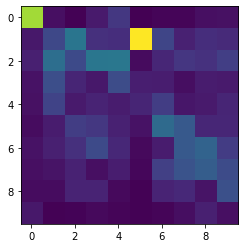

In [ ]:
from IPython.core.display import HTML, display
import torch as t
def display_attention(attn_matrix, tokens):
    attn_matrix = t.tensor(attn_matrix)
    attn_matrix = (attn_matrix).log()
    attn_matrix = t.nan_to_num(attn_matrix, neginf=np.pi)
    attn_matrix[attn_matrix==np.pi]=t.min(attn_matrix)
    attn_matrix = (attn_matrix-t.min(attn_matrix))/(t.max(attn_matrix)-t.min(attn_matrix))
    
    def get_color(scalar):
        np.log(scalar)
        h = int(scalar*100)
        return f'hsl({h}, 100%,50%)'
    htmlstring=f"""
    <style>
    .cell{{
    width:22px;
    height:22px;
    }}</style>
    <div style="display:flex; flex-direction:'row';">
        <div style="text-align:right;">
            {''.join([f'<div>{token}</div>' for token in tokens])}
        </div>
        <div>
            {''.join(['<div style="display:flex;">'+''.join([f'<div class="cell" style="background-color:{get_color(attn)};"></div>'
for attn in row])+'</div>' for row in attn_matrix])}
<div style="writing-mode: vertical-rl; text-orientation: mixed; display:flex; flex-direction:column-reverse;">{''.join([f'<div>{token}</div>' for token in tokens])}</div>
        </div>
    </div>
    """
    # print(htmlstring)
    return HTML(htmlstring)
display_attention([[0.9,1, 0],[1,0.9, 0], [0.9, 0, 1]], ['the', 'fire', "truck",])

/tmp/ipykernel_25930/4062742759.py:12: RuntimeWarning: divide by zero encountered in log
  np.log(scalar)


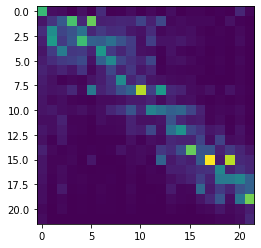

In [ ]:
show_aggregate_attention(model, "The capital of Germany is Berlin. The capital of England is London. The capital of France is Paris")

In [ ]:
import transformers
gpt2 = transformers.AutoModel.from_pretrained("gpt2-large")
print(gpt2.config)

Downloading:   0%|          | 0.00/666 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

GPT2Config {
  "_name_or_path": "gpt2-large",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "gradient_checkpointing": false,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 1280,
  "n_head": 20,
  "n_inner": null,
  "n_layer": 36,
  "n_positions": 1024,
  "resid_pdrop": 0.1,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.8.2",
  "use_cache": true,
  "vocab_size": 50257
}



In [ ]:
import torch
import transformers

tokenizer = transformers.AutoTokenizer.from_pretrained("gpt2")
model = transformers.AutoModelWithLMHead.from_pretrained("gpt2")
model = model.eval()



/home/ubuntu/.asdf/installs/python/3.9.6/lib/python3.9/site-packages/transformers/models/auto/modeling_auto.py:843: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


['This', ' is', ' some', ' example', ' text']


/tmp/ipykernel_25930/615927410.py:11: RuntimeWarning: divide by zero encountered in log
  np.log(scalar)


In [ ]:
def get_attention_pattern(text: str, attention_forces=[]):
    tokenization = tokenizer(text, return_tensors="pt")
    seq_length = len(tokenization["input_ids"][0])
    all_hooks = []
    try:
        attention_matrices_by_layer = {}

        def apply_all_hooks(parent_name, m, layer):
            attention_matrices_by_layer[layer] = []

            def hook(comp, inp, out):
                if out.shape[-2:] != (seq_length, seq_length):
                    return
                for entry in attention_forces:
                    # out's shape: [batch, head, to, from]
                    if entry["to"] < out.shape[2] and entry["from"] < out.shape[3] and entry["layer"] == layer:
                        out[0, entry["head"], entry["to"], :] = 0 
                        out[0, entry["head"], entry["to"], entry["from"]] = 1 
                attention_matrices_by_layer[layer].append(out.detach().cpu().numpy())

            if m._get_name() == "Dropout" and parent_name == "attn_dropout":
                handle = m.register_forward_hook(hook)
                all_hooks.append(handle)
            for k, v in m._modules.items():
                lower_layer = layer
                if v._get_name() == "GPT2Block":
                    lower_layer = int(k)
                apply_all_hooks(k, v, lower_layer)

        apply_all_hooks("?", model, None)
        outputs = model(
            **{k: v.to(model.device) for k, v in tokenization.items()},
        )
    finally:
        for hook in all_hooks:
            hook.remove()
    return attention_matrices_by_layer, outputs

o = get_attention_pattern(
    "This is some example text",
    [
        {
            "layer": 3,
            "head": 6,
            "from": 2,
            "to": 3,
        },
    ]
)
import torch as t
from einops import reduce, rearrange, repeat
def display_attention_pattern(text, attention_forces):
    pattern, _ = get_attention_pattern(text, attention_forces)
    tokens = ([tokenizer.decode([x]) for x in tokenizer(text)["input_ids"]])
    patterns=t.tensor([pattern[i] for i in range(12)])
    global_patterns = reduce(patterns, "layers d1 d2 heads from to -> from to", "mean")
    layer_patterns = reduce(patterns, "layers d1 d2 heads from to -> layers from to", "mean")
    return display(*[display_attention(layer_pattern, tokens) for layer_pattern in layer_patterns])
    return display_attention(global_patterns, tokens)
    
#display_attention_pattern("The fire hydrant is big and painted bright red.")
display_attention_pattern("Berlin is the capital of Germany. Paris is the capital of France. London is the capital of England.",[])

/tmp/ipykernel_25930/4062742759.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attn_matrix = t.tensor(attn_matrix)
/tmp/ipykernel_25930/4062742759.py:12: RuntimeWarning: divide by zero encountered in log
  np.log(scalar)
